## Check MC38 Chromosomes
Check the expression of genes on certain MC38 chromosomes.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from tqdm.notebook import tqdm
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
box_prefix = '/data/xyzeq/box.data/data/'
original_prefix = '/data/xyzeq/'

In [3]:
adata = sc.read_h5ad(box_prefix + 'all_batches_mouse_liver_tumor.h5ad')

In [4]:
batches = list()
for idx in adata.obs.index.str.split('_'):
    batches.append(idx[0])
adata.obs['batch'] = batches

In [5]:
adata.obs['batch'].value_counts()

L20T     27926
L20C1    26436
S15C     24410
L20C       153
Name: batch, dtype: int64

In [6]:
adata_with_annot = sc.read_h5ad(original_prefix + 'xyzeq/concatenated.deep/deep2/concat.deep.adata.m.and.h.combatted.dimred.subsetted.dimred.h5ad')

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [7]:
adata = adata[adata.obs['batch'] == 'L20C1'].copy()

In [8]:
adata.obs_names = [i + '-1' for i in adata.obs_names]

In [9]:
adata.obs = adata.obs.join(adata_with_annot.obs[['celltype1', 'celltype2']])

In [10]:
adata = adata[~(adata.obs['celltype1'].isna()),:]

In [11]:
gtf = pd.read_csv(original_prefix + 'refdata-cellranger-mm10-3.0.0/genes/genes.gtf', 
                  sep='\t', skiprows=5, low_memory=False, 
                  header=None)

In [12]:
gtf.columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]

In [13]:
chr_genes = dict()
chr_starts = dict()

In [14]:
additional_string = 'mm10___'

In [15]:
for chrom in tqdm(range(1,20)):
    chr_df = gtf[(gtf['seqname'] == str(chrom)) & (gtf['feature'] == 'exon')].copy()
    chr_genes[str(chrom)] = list()
    chr_starts[str(chrom)] = list()
    for attribute, start in zip(chr_df['attribute'].str.split("; "), chr_df['start']):
        
        # only take first 10 elements, last few cause problems
        chr_genes[str(chrom)].append(dict([tuple(j.split(' ')) for j in attribute][:10])['gene_name'].strip('"')) 
        
        chr_starts[str(chrom)].append(start)
    common_genes = np.intersect1d(adata.var_names.values, np.unique([additional_string + i for i in chr_genes[str(chrom)]]))
    bool_keep = [i in common_genes for i in [additional_string + i for i in chr_genes[str(chrom)]]]
    chr_genes[str(chrom)] = np.array(chr_genes[str(chrom)])[bool_keep]
    chr_starts[str(chrom)] = np.array(chr_starts[str(chrom)])[bool_keep]

In [16]:
adata_mouse = adata[adata.obs['celltype1'] != 'Human'].copy()

In [17]:
cts = adata_mouse.obs['celltype1'].dtype.categories
chr_counts = pd.DataFrame(0, index=range(1,20), columns=cts)

In [18]:
for chrom, ct in tqdm(it.product(chr_counts.index.values, chr_counts.columns.values)):
    genes = ['mm10___' + i for i in np.unique(chr_genes[str(chrom)])]
    chr_counts.loc[chrom, ct] = adata_mouse[adata_mouse.obs['celltype1'] == ct][:,genes].X.mean()

In [19]:
adata_mouse[adata_mouse.obs['celltype1'] == ct][:,genes].X.mean()

0.07760271

In [20]:
tidy_counts_hepato_mc38 = chr_counts[['MC38', 'Hepato']]
tidy_counts_hepato_mc38.index = tidy_counts_hepato_mc38.index.rename('chr')
tidy_counts_hepato_mc38 = tidy_counts_hepato_mc38.reset_index()
tidy_counts_hepato_mc38 = tidy_counts_hepato_mc38.melt(id_vars='chr')
tidy_counts_hepato_mc38.columns = ['chr', 'ct', 'counts']

In [21]:
tidy_counts_hepato_mc38

,chr,ct,counts
0,1,MC38,0.045924
1,2,MC38,0.038992
2,3,MC38,0.041771
3,4,MC38,0.044252
4,5,MC38,0.046442
5,6,MC38,0.046731
6,7,MC38,0.028000
7,8,MC38,0.048962
8,9,MC38,0.041564
9,10,MC38,0.056066


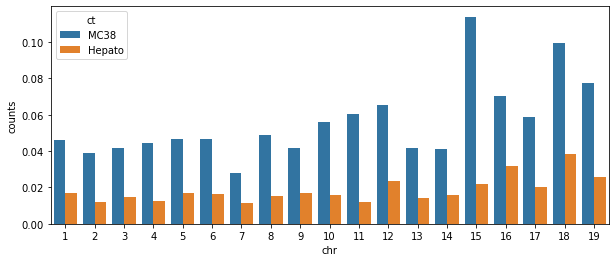

In [22]:
plt.figure(figsize=(10, 4))
sns.barplot(data=tidy_counts_hepato_mc38, x='chr', y='counts', hue='ct');

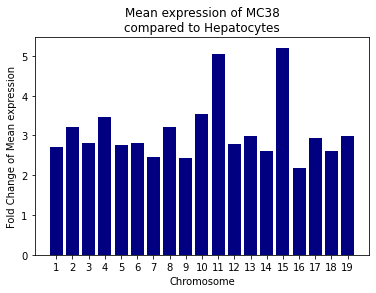

In [37]:
plt.bar(np.arange(1,20).astype(str), chr_counts['MC38'].divide(chr_counts['Hepato']).values, color='navy');
plt.xlabel('Chromosome')
plt.ylabel('Fold Change of Mean expression')
plt.title('Mean expression of MC38\ncompared to Hepatocytes');

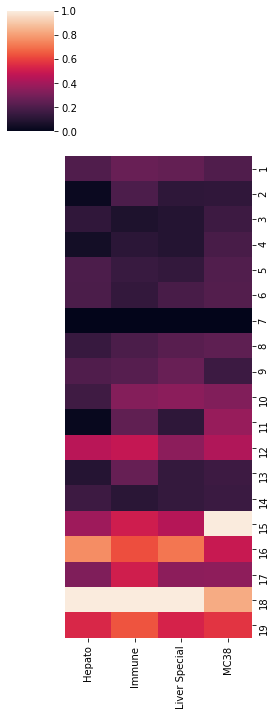

In [33]:
sns.clustermap(chr_counts, standard_scale=1, row_cluster=False, col_cluster=False, figsize=(4,10));
plt.tight_layout()
# plt.savefig(fname=original_prefix + 'xyzeq/figures/mc38.expression.by.chr.svg', dpi=80)

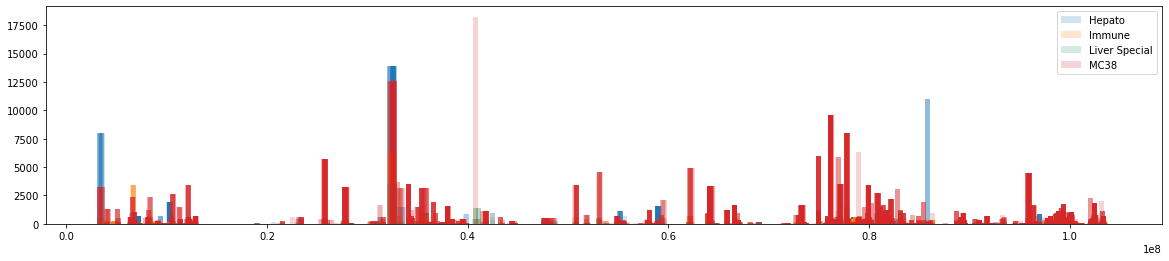

In [124]:
chrom = '15'
plt.figure(figsize=(20,4))
for ct, color in tqdm(zip(cts, sc.pl.palettes.default_20[:len(cts)])):
    counts = np.array(adata_mouse[adata_mouse.obs['celltype1'] == ct][:,[additional_string + i for i in chr_genes[chrom]]].X.sum(0))[0]
    starts = chr_starts[chrom]
    sample_number = 5000
    idxs = np.random.choice(np.arange(len(counts)), size=sample_number, replace=False)

    plot_counts = counts[idxs]
    plot_starts = starts[idxs]

    plt.bar(plot_starts, plot_counts, width=500000, alpha=0.2, color=color, label=ct)
plt.legend()
plt.show()

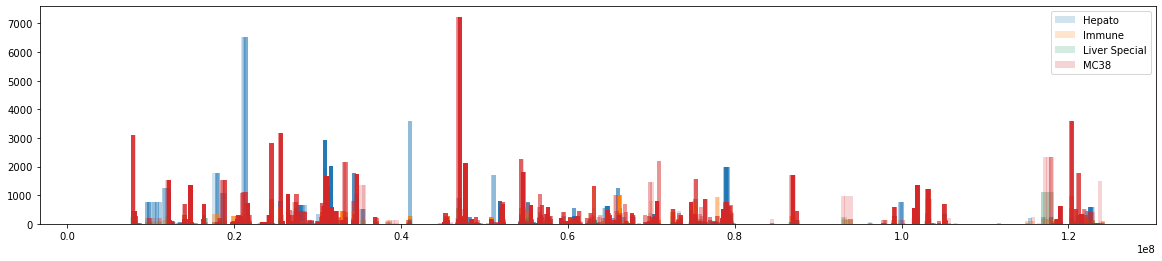

In [126]:
chrom = '14'
plt.figure(figsize=(20,4))
for ct, color in tqdm(zip(cts, sc.pl.palettes.default_20[:len(cts)])):
    counts = np.array(adata_mouse[adata_mouse.obs['celltype1'] == ct][:,[additional_string + i for i in chr_genes[chrom]]].X.sum(0))[0]
    starts = chr_starts[chrom]
    sample_number = 5000
    idxs = np.random.choice(np.arange(len(counts)), size=sample_number, replace=False)

    plot_counts = counts[idxs]
    plot_starts = starts[idxs]

    plt.bar(plot_starts, plot_counts, width=500000, alpha=0.2, color=color, label=ct)
plt.legend()
plt.show()

In [130]:
list(zip(cts, sc.pl.palettes.default_20[:len(cts)]))

[('Hepato', '#1f77b4'),
 ('Immune', '#ff7f0e'),
 ('Liver Special', '#279e68'),
 ('MC38', '#d62728')]

index
L10C_P1A01F.AGACGTCCTCCGCCTA-0    Hepato
L10C_P1A01F.AGCACTGCATGGCCAG-0    Immune
L10C_P1A01F.ATCCAGTGCTTACTCT-0    Hepato
L10C_P1A01F.ATTCGCACGCGGCTTC-0    Hepato
L10C_P1A01F.CACGACCTCACGACTA-0    Immune
                                   ...  
L30C_P2H12F.TACAGTGTCGCGCTTA-3      MC38
L30C_P2H12F.TATAAGCCGACGACGC-3      MC38
L30C_P2H12F.TCTTACCAAGAGGCTT-3    Immune
L30C_P2H12F.TTCTTACGTCCATGAG-3    Hepato
L30C_P2H12F.TTGGACGTGAGATAGT-3    Hepato
Name: celltype1, Length: 30206, dtype: category
Categories (4, object): [Hepato, Immune, Liver Special, MC38]